# Laboratorio 1 MA4702-2021
# Resolución de Steiner Tree por generación de filas


# Instrucciones.

Este laboratorio tiene 5 ejercicios. Los ejercicios 1, 2 y 3 se deben entregar hoy a las 18:00.
Si bien el es recomendable terminar los 5 ejercicios hoy (la actividad está planeada para máximo 2.5 horas).
Usted tendrá plazo hasta el Viernes 30 de abril a las 23:59 para entregar su versión completa

* Complete la celda "A. Datos grupo y Observaciones".
* Descargue los archivos de instancias de ucursos.
* Lea el enunciado y complete AL MENOS los ejercicios 1, 2, 3.
* Una vez terminada, ejecute el archivo jupyter completo usando (Kernel: Restart and Run All), o bien usando (Kernel: Restart and Clean Output) y luego ejecutando manualmente las celdas una a una en orden.
* Guarde el archivo .ipynb resultante con un nombre a su elección y súbalo por el modulo de tareas de ucursos en la TAREA: Laboratorio 1 presencial 
* Plazo de entrega:  ** Miércoles 28 de abril las 18:00 ** 

La versión completa se debe entregar el viernes, para ello:

* Si actualizó alguna parte de los ejercicios entregados el miércoles, describa brevemente los cambios en la celda A.
* Una vez terminada, ejecute el archivo jupyter completo usando (Kernel: Restart and Run All), o bien usando (Kernel: Restart and Clean Output) y luego ejecutando manualmente las celdas una a una en orden.
* Guarde el archivo .ipynb resultante con un nombre a su elección y súbalo por el modulo de tareas de ucursos en la TAREA: Laboratorio 1 completo.


# 🔴A. Datos grupo y Observaciones

Escriba en esta celda el nombre de cada integrante de su grupo.

- Integrante 1: Axel Kolm

- Integrante 2: Daniel Minaya Vargas

- Integrante 3: Diego Dominguez

- Integrante 4: Fabián Sepúlveda

- Integrante 5: Francisco Maldonado


## Observaciones

- Si tiene alguna observación a la corrección escríbala acá.

# 🔴 B. Preparación

* Usaremos los paquetes JuMP, Gurobi, Distances y Plots.
  Descomente las lineas si no tiene los paquetes y asegúrese de tener la última versión de JuMP corriendo (0.21.7 en abril 2021)

In [1]:
@show(Sys.BINDIR)
versioninfo()
import Pkg
# Descomente los siguientes comandos y vuelvalos a comentar una vez que los ejecute
#Pkg.add("Distances")
#Pkg.add("Plots")
#Pkg.update("JuMP")

Sys.BINDIR = "C:\\Users\\Daniel Minaya Vargas\\AppData\\Local\\Programs\\Julia-1.6.0\\bin"
Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
Pkg.status("JuMP")
using JuMP, Gurobi, Distances, Plots
const GUROBI_ENV = Gurobi.Env() # Abrir un solo ambiente de Gurobi, 
# Jupyter se marea si se crean demasiados modelos durante en una misma celda, esto lo evita.
include("preparacion.jl");

      Status `C:\Users\Daniel Minaya Vargas\.julia\environments\v1.6\Project.toml`
  [4076af6c] JuMP v0.21.7
Academic license - for non-commercial use only - expires 2021-05-22


El archivo "preparacion.jl", descrito a continuación, tiene  funciones preescritas que necesitaremos.

```julia
dibujapesos(coordx,coordy,pesos)
## Recibe dos arreglos de N valores donde (coordx[i],coordy[i]) son las coordenadas de la ciudad i
## Recibe además una matriz arcos de N x N, donde pesos[i,j] es el peso del arco [i,j]
## Dibuja los N puntos en el plano y dibuja las aristas con ancho de linea proporcional a su peso.

dibujaaristas(coordx,coordy,aristas)
## Recibe dos arreglos de N valores donde (coordx[i],coordy[i]) son las coordenadas de la ciudad i
## Recibe además una lista de aristas 
## Dibuja los N puntos en el plano y dibuja las aristas corespondientes con ancho de linea proporcional al peso.

leearchivo(nombre_archivo)
## Recibe un archivo con las coordenadas de N ciudades, devolviendo N, las coordenadas x, las coordenadas y.

encuentracomponente(N,v,aristas)
# Encuentra los vértices de la unica componente que contiene a v en el grafo (1:N, aristas)
# Esto es hecho usando DFS, por lo que si esta componente es un ciclo
# la reporta en el orden del mismo ciclo.

function encuentracomponentedirigida(N, v, arcos)
# Encuentra los vértices alcanzables desde  v en el digrafo (1:N, arcos)
```


## IMPORTANTE

En este laboratorio resolveremos el problema del árbol de Steiner. Como ayuda para resolverlo dispondremos de una solución completa de un problema muy similar, que es el problema del vendedor viajero.

La solución completa para TSP se encuentra en el archivo `Lab2021-01-TSP.ipynb`


# 🔴C. Definición de los problemas TSP y Steiner Tree (en el plano)




## TSP. Vendedor viajero

Dado un conjunto $V$ de ubicaciones (ciudades) del plano, deseamos encontrar un tour (ciclo hamiltoniano) $C$ que pase por cada una exactamente una vez, de largo total mínimo. Este problema es NP-completo y difícil de abordar en toda generalidad.

## Steiner Tree. Árbol de Steiner

Dado un conjunto $V$ de ubicaciones del plano y un subconjunto $S\subseteq V$ de **terminales**, deseamos encontrar un árbol $T$ que conecte a los terminales $S$, de costo mínimo, donde $T$ puede usar, además, elementos de $V\setminus T$ como vértices  intermedios. Formalmente, buscamos $T=(W,E)$ árbol de costo mínimo donde $S\subseteq W\subseteq V$.


## Formulaciones para TSP y Steiner Tree

Hay *muchas* formas de modelar **TSP** y **Steiner Tree** como programas lineales mixtos, algunas de ellas tienen formulaciones de tamaño polinomial. Dichas formulaciones tienden a ser poco exactas (lo que causa que un solver debe realizar demasiadas ramificaciones de Branch and Bound para resolverlas). Por ello, se estudian formulaciones con un número exponencial de restricciones. En este laboratorio, trabajaremos con dichas formulaciones de manera implícita, es decir sin tener que escribir todas las restricciones.

Por simplicidad, siempre usaremos $V=[N]$ para denotar a las $N$ ubicaciones y $E=\{(i,j)\colon 1\leq i<j \leq n\}$ para referirnos a las posibles aristas (no dirigidas) del grafo completo asociado a esas ubicaciones.

### Modelo DFZ (Dantzig-Fulkerson-Johnson) no dirigido para TSP.
Datos. $(d_e\colon e\in E)$ son la distancias entre las ciudades. 
Variables: $z_e$ para todo $e\in E$ que representarán la indicatriz del ciclo.

\begin{align*}
(\text{DFZ})\qquad \min &\sum_{e\in E} z_{e}d(e)\\
z(\delta(v))&=2, & \forall v\in V.\quad &(\text{grado}(v))\\
z(\delta(U))&\geq 2,& \forall U\subseteq V, 1\in U, U\neq V.\quad &(\text{corte}(U))\\
0\leq z_e &\leq 1, &\forall e\in E.\quad &(\text{cotas}(e))\\
z &\in \mathbb{Z}^{E}.& &(\text{integralidad})
\end{align*}

Las restricciones de cotas e integralidad indican que cada $z_e$ toma un valor binario (0 o 1), luego $z$ es un vector indicatriz de un conjunto de aristas $F$.

Las restricciones de grado indican que cada vértice debe tener grado 2 en el conjunto de aristas solución.

Las restricciones de corte indican que para cada conjunto $U$ que contenga al menos un vértice y que tenga al menos un vértice fuera, el ciclo debe "entrar y salir" una vez al menos a $U$, luego el corte debe incluir al menos 2 aristas.


### Modelo  steiner-tree simple.
Datos. $(d_e\colon e\in E)$ son la distancias entre las ubicaciones. 
$S\subseteq V$, conjunto de terminales, tal que $1\in S$.

Variables: 
$x_e$ para todo $e\in E$ que representarán la indicatriz del árbol.


\begin{align*}
(\text{STS})\qquad \min &\sum_{e\in E} x_{e}d(e)\\
x(\delta(v))&\geq 1, &\forall v\in S.\quad &(\text{cortesimple}(v))\\
x(\delta(U))&\geq 1, &\forall U \subseteq V, 1\in U, S\setminus U \neq \emptyset.\quad &(\text{corte}(U))\\
0\leq x_e &\leq 1, &\forall e\in E.\quad &(\text{cotas}(e))\\
x &\in \mathbb{Z}^{E}.& &(\text{integralidad } x)\\
\end{align*}

Las restricciones de cotas e integralidad indican que cada $x_e$ toma un valor binario (0 o 1), luego $x$ es un vector indicatriz de un conjunto $F$ de aristas.

La restricción de corte indica que para cada conjunto $U$ que contiene algún terminal dentro y algún terminal fuera, debe existir al menos una arista de $F$ en $\delta(U)$.

La restricción de corte simple es una especialización de la reststricción de corte (está implicada por ellos). Si bien no es necesario incluirlas de manera separada, en este laboratorio serán utiles como punto de partida.



# 🔴 D. Generación iterativa de PLE. 

Ambos modelos presentados poseen una cantidad exponencial de restricciones (las llamadas "corte"). Esto hace intractable escribir todas las restricciones y luego usar un solver para resolverlo. En lugar de eso tomaremos la siguiente ruta para ambos modelos. En la literatura, las restricciones que deseamos tratar implícitamente son llamadas  **restricciones flojas** (**lazy constraints**). En nuestro caso, las restricciones flojas son las restricciones de corte.

> 1. Escribir **modelo incompleto** con variables **integrales** sin las restricción flojas
>
> 2. Repetir:  Resolver el modelo actual y sea $F$ el conjunto de aristas asociados a la solución entera.  
    > 2.1  
    > (Para DFZ). Si $F$ no es un ciclo hamiltoniano, buscar **una o mas** restricciones flojas insatisfechas corte($U$) y agregarlas.  
    > (Para EST). Si $F$ no es un árbol de Steiner, buscar **una o mas** restricciones flojas  insatisfechas  corte($U$) y agregarlas.  
    > 2.2  
    > En otro caso, el conjunto $F$ es la solución óptima del problema.

El procedimiento que dado $F$ busca una restricción floja insatisfecha o declara que no hay se conoce como oráculo entero de restricciones flojas.

## 🔥 Ejercicio 1 (10 puntos)

NOTA: Para este ejercicio, puede basarse en la función ```creaModeloTSP``` ubicada en el archivo `Lab2021-01-TSP.ipynb`

En las siguientes celdas realice: 

1.a) Escriba una función ```creaModeloSTS(N,coordx,coordy,S)```
     que retorne un modelo tipo STS para steiner tree. **Este modelo no debe incluir las restricciones de corte** (pero si las de corte simple)   
1.b) Usando S=collect(1:10), lea el archivo i20.txt y cree el modelo asociado.  
1.c) Optimice, muestre el valor objetivo y recupere el conjunto F indicatriz asociado a la solución.  
1.d) Dibuje la solucion, encuentre la componente $U$ que contiene a 1 y muestre el conjunto $W$ de vértices de Steiner (no terminales) que este cubre (si hubiera).

In [3]:
# 1.a) Escriba una función ```creaModeloSTS(N,coordx,coordy,S)```
# que retorne un modelo tipo STS para steiner tree. Este modelo no debe incluir las restricciones de corte.

function creaModeloSTS(N,coordx, coordy, S)
    
    # Inicializar modelo y condiciones del solver
    STS = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV))) # para multiples modelos en jupyter
    set_optimizer_attributes(STS, "OutputFlag" => 0, "TimeLimit" => 80)
    
    # Crear variables, objetivos y restricciones
    E=[[i,j] for i in 1:N, j in 1:N if i<j]
    @variable(STS, 0<=x[i in 1:N,j in 1:N; [i,j] in E]<=1, Int)   
    @objective(STS, Min, sum(x[e[1],e[2]]*euclidean([coordx[e[1]],coordy[e[1]]],[coordx[e[2]],coordy[e[2]]]) for e in E))
    @constraint(STS, grado[i in S], sum(x[e[1],e[2]] for e in E if i in e)>=1)
    
    # Devolver modelo
    return STS
end
 

creaModeloSTS (generic function with 1 method)

In [4]:
# 1.b) Usando S=collect(1:10), lea el archivo i20.txt y cree el modelo asociado.  
S=collect(1:10)
N,posx,posy=leearchivo("i20.txt")
STS=creaModeloSTS(N,posx,posy,S);

In [5]:
# 1.c) Optimice, muestre el valor objetivo y recupere el conjunto F indicatriz asociado a la solución.
# optimizar y recuperar vector indicatriz.
optimize!(STS)
@show(objective_value(STS));
F=[[i,j] for i in 1:N, j in 1:N if i<j && value(STS[:x][i,j]) ≈ 1];
@show(F);

objective_value(STS) = 31.812106891197693
F = [[4, 7], [2, 8], [5, 10], [6, 11], [1, 12], [3, 13], [9, 16]]


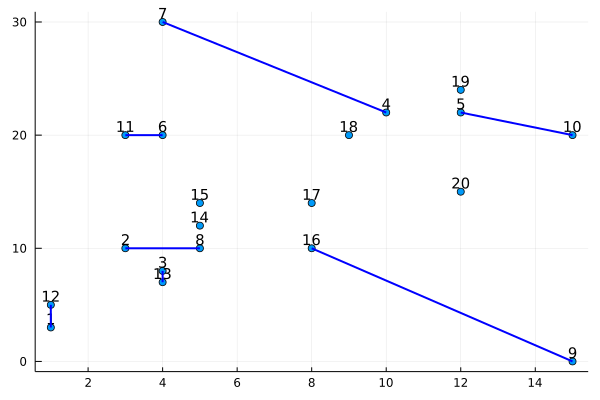

U = [1, 12]
W = [12]


In [6]:
# 1.d) Dibuje la solucion. Encuentre la componente U que contiene a 1 usando encuentracomponente(N,v,aristas) 
# y muestre el conjunto W de vértices de Steiner (no terminales) que esta componente cubre (si hubiera).
U=encuentracomponente(N,1,F);
dibujaaristas(posx,posy,F);
@show(U);

W=Int64[]
for v in U
    if !(v in S)
        append!(W, v)
    end
end 
@show(W);

## 🔥 Ejercicio 2 (10 puntos)

NOTA: Para este ejercicio, puede basarse en la función ```resuelveDFZ``` ubicada en el archivo `Lab2021-01-TSP.ipynb`
En dicho complemento solo se agrega 1 corte por iteracion.
Para Steiner Tree esto es **muy ineficiente** por lo cual es mejor agregar múltiples cortes por iteración como sigue:

Sea $F$ indicatriz asociada a una solución entera $z$ que satisfaga las condiciones de cotas y de corte simple.
Si existe una componente conexa de $(V,F)$ que contenga a todos los terminales entonces $F$ cumple todas las restricciones de corte.
En otro caso, cada componente conexa $U$ de $(V,F)$ que posea terminales satisface $z(\delta(U))=0$, y luego  la restricción (corte$(U)$) no está satisfecha. 

2.1) Complete la función ```resuelveSTS``` que dado un archivo, resuelve Steiner Tree para la instancia asociada.
En cada iteración debe agregar un corte para cada componente conexa de $(V,F)$ que posea algún terminal (exceptuando el caso en el que haya una sola componente que posea todos los terminales). Se usa un maximo de 80 iteraciones, si luego de esa cantidad no ha terminado, se manda un error.

2.2) Ejecute esta función (tomando el tiempo usado) en las instancias guardadas en los archivos i20.txt, i40.txt, i50.txt

In [7]:
# 2.1)  Complete la función resuelveSTS que dado un archivo, resuelve STS para la instancia asociada
# mediante el método explicado anteriormente. 

function resuelveSTS(nombre_archivo, S)
    
    # Crear modelo inicial 
    N,posx,posy = leearchivo(nombre_archivo)
    E=[[i,j] for i in 1:N, j in 1:N if i<j]
    STS=creaModeloSTS(N,posx,posy,S);
    
    # iterar (guardando número de iteraciones simplex calculadas)
    limite=80 
    itera=0
    cortesagregados=0
    simplex=0
    
    while(itera<limite) 
        # optimizar modelo actual y recuperar vector indicatriz
        optimize!(STS)
        F=[[i,j] for i in 1:N, j in 1:N if i<j && value(STS[:x][i,j]) ≈ 1]; 
        
        # sumar a simplex el número de iteraciones usadas
        simplex=simplex + simplex_iterations(STS)
        
        # encontrar componente U que tiene a 1. 
        Aux = S
        for i in S
            if i in Aux
                U = encuentracomponente(N,i,F)
                Aux=setdiff(Aux,U)
                K=setdiff(S,U) # terminales fuera de U

                if(length(K)==0) # si la componente toca todos los terminales, terminales calcular el valor del árbol y dibujarlo.
                    valor=objective_value(STS)
                    display("Número de iteraciones: $itera")
                    display("Número de cortes agregados: $cortesagregados")
                    display(string("Número de pasos simplex:", Int(simplex)))                        
                    display("Árbol óptimo encontrado, de largo $valor")
                    display(string("Vértices de Steiner usados: ", setdiff(U,S)))
                    dibujaaristas(posx,posy,F)
                    return nothing

                    else # la componente no toca todos los terminales, luego se debe añadir una restriccion de corte por cada componente
                    #para cada componente 
                        @constraint(STS, sum(STS[:x][e[1],e[2]] for e in E if (e[1] in U && !(e[2] in U)) || (e[2] in U && !(e[1] in U)))>=1)
                        cortesagregados+=1
                end 
            end
        end
    
    itera=itera+1
    println("Iteración $itera, cortes $cortesagregados")                                                
    end
    if(itera==limite)
            @warn("Exceso de iteraciones")
    end
    return nothing
end


resuelveSTS (generic function with 1 method)

Iteración 1, cortes 7
Iteración 2, cortes 11
Iteración 3, cortes 17
Iteración 4, cortes 21
Iteración 5, cortes 25
Iteración 6, cortes 29
Iteración 7, cortes 34
Iteración 8, cortes 38
Iteración 9, cortes 43
Iteración 10, cortes 45
Iteración 11, cortes 49
Iteración 12, cortes 53
Iteración 13, cortes 56
Iteración 14, cortes 59
Iteración 15, cortes 63
Iteración 16, cortes 67
Iteración 17, cortes 71
Iteración 18, cortes 74
Iteración 19, cortes 78
Iteración 20, cortes 82
Iteración 21, cortes 85
Iteración 22, cortes 88
Iteración 23, cortes 91
Iteración 24, cortes 93
Iteración 25, cortes 95
Iteración 26, cortes 98
Iteración 27, cortes 101
Iteración 28, cortes 103
Iteración 29, cortes 106
Iteración 30, cortes 109
Iteración 31, cortes 113
Iteración 32, cortes 115
Iteración 33, cortes 117
Iteración 34, cortes 120
Iteración 35, cortes 123
Iteración 36, cortes 126
Iteración 37, cortes 129
Iteración 38, cortes 132
Iteración 39, cortes 134
Iteración 40, cortes 136
Iteración 41, cortes 138

"Número de iteraciones: 42"

"Número de cortes agregados: 140"

"Número de pasos simplex:134420"

"Árbol óptimo encontrado, de largo 55.254455004826724"

"Vértices de Steiner usados: [13]"

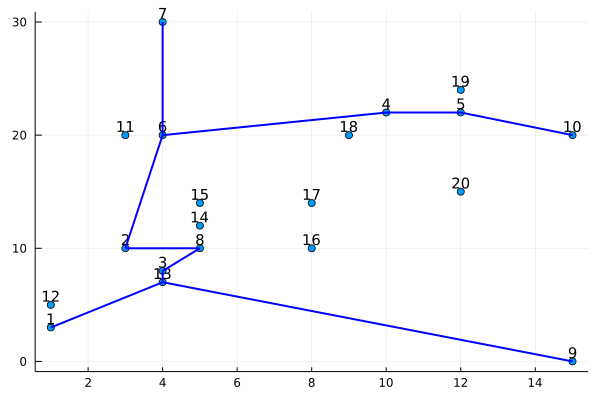


Iteración 42, cortes 140
 31.619789 seconds (1.23 M allocations: 66.872 MiB, 0.11% gc time, 4.60% compilation time)


In [8]:
# 2.2) Ejecute esta función (tomando el tiempo usado) en las instancias guardadas en los archivos
# i20.txt, i40.txt, i50.txt. Use en todos los ejemplos S=collect(1:10)

# i20.txt
@time(resuelveSTS("i20.txt", collect(1:10)))

Iteración 1, cortes 6
Iteración 2, cortes 13
Iteración 3, cortes 20
Iteración 4, cortes 26
Iteración 5, cortes 32
Iteración 6, cortes 37
Iteración 7, cortes 41
Iteración 8, cortes 45
Iteración 9, cortes 49
Iteración 10, cortes 54
Iteración 11, cortes 59
Iteración 12, cortes 63
Iteración 13, cortes 67
Iteración 14, cortes 72
Iteración 15, cortes 76
Iteración 16, cortes 82
Iteración 17, cortes 86
Iteración 18, cortes 90
Iteración 19, cortes 93
Iteración 20, cortes 97
Iteración 21, cortes 101
Iteración 22, cortes 106
Iteración 23, cortes 110
Iteración 24, cortes 114
Iteración 25, cortes 118
Iteración 26, cortes 122
Iteración 27, cortes 125
Iteración 28, cortes 128
Iteración 29, cortes 132
Iteración 30, cortes 135
Iteración 31, cortes 138
Iteración 32, cortes 142
Iteración 33, cortes 145
Iteración 34, cortes 148
Iteración 35, cortes 151
Iteración 36, cortes 154
Iteración 37, cortes 156
Iteración 38, cortes 158
Iteración 39, cortes 162
Iteración 40, cortes 164
Iteración 41, cortes 166
Itera

"Número de iteraciones: 70"

"Número de cortes agregados: 233"

"Número de pasos simplex:1471427"

"Árbol óptimo encontrado, de largo 214.40286412742626"

"Vértices de Steiner usados: [34, 16]"

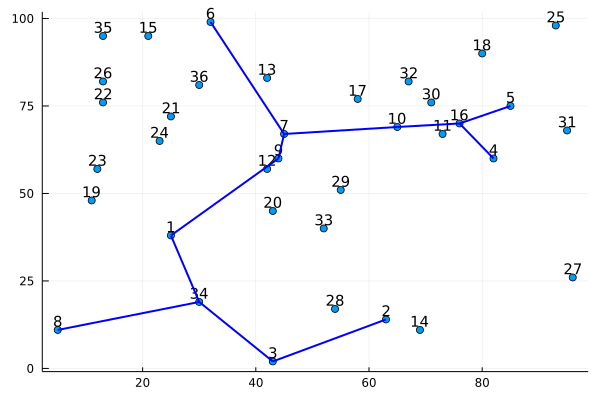

Iteración 70, cortes 233
137.752000 seconds (1.32 M allocations: 47.785 MiB, 0.07% gc time, 0.04% compilation time)


In [9]:
# i40.txt
@time(resuelveSTS("i40.txt", collect(1:10)))

In [10]:
# i50.txt
@time(resuelveSTS("i50.txt", collect(1:10)))

Iteración 1, cortes 7
Iteración 2, cortes 13
Iteración 3, cortes 19
Iteración 4, cortes 24
Iteración 5, cortes 30
Iteración 6, cortes 35
Iteración 7, cortes 40
Iteración 8, cortes 44
Iteración 9, cortes 48
Iteración 10, cortes 51
Iteración 11, cortes 56
Iteración 12, cortes 60
Iteración 13, cortes 65
Iteración 14, cortes 69
Iteración 15, cortes 72
Iteración 16, cortes 76
Iteración 17, cortes 80
Iteración 18, cortes 84
Iteración 19, cortes 88
Iteración 20, cortes 91
Iteración 21, cortes 95
Iteración 22, cortes 97
Iteración 23, cortes 102
Iteración 24, cortes 104
Iteración 25, cortes 107
Iteración 26, cortes 110
Iteración 27, cortes 113
Iteración 28, cortes 118
Iteración 29, cortes 122
Iteración 30, cortes 125
Iteración 31, cortes 128
Iteración 32, cortes 130
Iteración 33, cortes 134
Iteración 34, cortes 138
Iteración 35, cortes 141
Iteración 36, cortes 145
Iteración 37, cortes 148
Iteración 38, cortes 150
Iteración 39, cortes 153
Iteración 40, cortes 156
Iteración 41, cortes 159
Iteraci

┌ Warning: Exceso de iteraciones
└ @ Main In[7]:55


***

# 🔴 E. Implementación mediante generación de filas usando lazy-constraints-callbacks.

La técnica usada en la parte D permite resolver Steiner Tree para instancias de tamaño moderado resolviendo una serie de PLE con más y más restricciones. En cada uno de estos PLE, el solver debe realizar branch and bound sin necesariamente reutilizar el trabajo anterior.

Una manera de hacer este proceso de manera más eficiente es realizar una sola ejecución de branch and bound
y agregar estas restricciones al modelo no al final del mismo si no cada vez que se encuentra un incumbente.
Los solvers modernos permiten pausar branch and bound en algunos puntos clave, luego llamar a una función externa
y finalmente despausar la ejecución (a esto se le llama un callback).

En esta sección implementaremos una función callback del tipo lazy-constraint.
Esta función será llamada cada vez que Gurobi encuentra un incumbente y permite 
1. Recuperar el valor del incumbente.
2. Usar el valor del incumbente para generar una o varias restricciones floja (en caso que exista).
3. Agrega estas restricciones al modelo antes de continuar a BnB.


El modo de implementar una función callback en jump+gurobi (en genérico) es como sigue:

supongamos que ya tenemos un modelo llamado mi_modelo, en Julia podemos escribir lo siguiente

```julia
   
   function mi_callback(cb_data)
      # callback_value es el comando para recuperar valor de la o las variable que necesitemos, por ejemplo
      # si deseamos recuperar todas las variables w[i,j] para i de 1:5, j de 1:5 y guardar sus valores en 
      # una matriz AUX se puede escribir
      AUX=zeros(5,5)
      for i in 1:5, j in 1:5
          AUX[i,j] = callback_value(cb_data, mi_modelo[:w][i,j])
      end

      # Nota: la implementación actual de Gurobi podría llamar a esta función cuando la solución es todavía fraccional
      #      que conviene revisar integralidad. Para hacer esto con la matriz AUX anterior, puede escribir
        
      tolerancia=0.001
      if (!all( u-> abs(u-round(u))<tolerancia, AUX))
          display(string("callback en solución fraccional"))
          return nothing
        end
        
      # si se pasa el test anterior, sabemos que AUX es integral, luego podemos usarla para 
      # buscar restriccion nueva (restricción floja) que agregar
      
      ..
      # comandos para buscar restricción floja acá
      ..
      # para cada restriccion nueva construirla y mandarla
      restriccion_nueva = @build_constraint(mi_modelo,  .. escribir restriccion ..)
      MOI.submit(mi_modelo, MOI.LazyConstraint(cb_data), restriccion_nueva)
      
      end
    end

```

Una vez que la función esté creada debemos **agregarla al modelo**, eso se hace mediante el siguiente comando

```julia
    MOI.set(mi_modelo, MOI.LazyConstraintCallback(), mi_callback)
```
    

## 🔥 Ejercicio 3.  (10 puntos)

NOTA: Para este ejercicio, básese en la función ```resuelveDFZconCallbacks``` ubicada en el archivo `Lab2021-01-TSP.ipynb`

3.1) Complete la funcion ```resuelveSTSconCallbacks``` para resolver Steiner Tree usando callbacks. Nuevamente agregue una restricción por cada componente conexa de su solución parcial.

3.2) Ejecute su funcion en tres instancias (i20.txt, i40.txt, i50.txt), usando en todas ellas S=collect(1:10).


In [11]:
# 3.1) Complete la funcion ```resuelveSTSconCallbacks``` para resolver Steiner Tree usando callbacks.

function resuelveSTSconCallbacks(nombrearchivo, S)
    # note que su función recibe además S
    # Crear modelo STS inicial 
    
    N,posx,posy = leearchivo(nombrearchivo)
    E=[[i,j] for i in 1:N, j in 1:N if i<j]
    STS=creaModeloSTS(N,posx,posy,S);
    
    # Implementar función callback
    cortesagregados=0
    callbacks=0
    function mi_callback(cb_data)
        callbacks+=1
        # Recupera valores intermedios de cb_data y STS[:x]
        x_val=zeros(N,N)
        for i=1:N, j=i+1:N
            x_val[i,j] = callback_value(cb_data, STS[:x][i,j])
        end 
        
        # Revisar fraccionalidad del vector de valores encontrado, si no es integral, return nothing
        tolerancia=0.001
        if (!all( u-> abs(u-round(u))<tolerancia, x_val))
          display(string("callback en solución fraccional"))
          return nothing
        end
        
        # Encontrar vector indicatriz F asociado
        F=[[i,j] for i in 1:N, j in 1:N if i<j && x_val[i,j] ≈ 1];
        
        #  encontrar componente U que tiene a 1. 
        for i in S
            U=encuentracomponente(N,i,F)
            K =setdiff(S,U)

            if(length(K)==0) # si la componente toca a todos los terminales, salir de la funcion
                return nothing
                else   # la componente no toca todos los terminales, contruir restricciones nuevas, una por cada componente
                    for t in K #para cada componente 
                        restriccion_nueva = @build_constraint(sum(STS[:x][e[1],e[2]] for e in E if (e[1] in U && !(e[2] in U)) || (e[2] in U && !(e[1] in U)))>=1)
                        MOI.submit(STS, MOI.LazyConstraint(cb_data), restriccion_nueva)
                        cortesagregados+=1
                        K=setdiff(K,U)
                    end 
            end
        end
        
        println("callbacks $callbacks, cortes $cortesagregados")
    end                        
    
    # Agregar función al modelo STS
    MOI.set(STS, MOI.LazyConstraintCallback(), mi_callback)

    # Optimizar, reportar solución y dibujar.
    optimize!(STS)
    F=[[i,j] for i in 1:N, j in 1:N if i<j && value(STS[:x][i,j]) ≈ 1];
    U=encuentracomponente(N,1,F) 
    valor=objective_value(STS)
    display(string("Árbol óptimo encontrado, de largo ", length(U)))
    display(string("Número de pasos simplex:", Int(simplex_iterations(STS))))
    display(string("Número de callbacks:", callbacks))
    display(string("Número de cortes agregados:", cortesagregados))
    display(string("Vértices de Steiner usados: ", setdiff(U,S)))
    display(string("Valor óptimo alcanzado: ", valor))

    dibujaaristas(posx,posy,F)
    return nothing
end    

resuelveSTSconCallbacks (generic function with 1 method)

callbacks 2, cortes 84
callbacks 3, cortes 158
callbacks 4, cortes 208
callbacks 5, cortes 270
callbacks 6, cortes 336
callbacks 7, cortes 368
callbacks 8, cortes 442
callbacks 9, cortes 512
callbacks 10, cortes 544
callbacks 12, cortes 602
callbacks 13, cortes 680
callbacks 14, cortes 730
callbacks 15, cortes 792
callbacks 16, cortes 864
callbacks 17, cortes 930
callbacks 18, cortes 996
callbacks 19, cortes 1070
callbacks 20, cortes 1120
callbacks 21, cortes 1194
callbacks 22, cortes 1256
callbacks 23, cortes 1330
callbacks 24, cortes 1392
callbacks 25, cortes 1442
callbacks 26, cortes 1514
callbacks 27, cortes 1578
callbacks 28, cortes 1636
callbacks 29, cortes 1684
callbacks 30, cortes 1716
callbacks 31, cortes 1758
callbacks 32, cortes 1832
callbacks 33, cortes 1896
callbacks 34, cortes 1960
callbacks 35, cortes 2024
callbacks 36, cortes 2088
callbacks 37, cortes 2154
callbacks 38, cortes 2202
callbacks 40, cortes 2250
callbacks 41, cortes 2314
callbacks 42, cortes 2372
callbacks 4

"Árbol óptimo encontrado, de largo 11"

"Número de pasos simplex:10833"

"Número de callbacks:52"

"Número de cortes agregados:2744"

"Vértices de Steiner usados: [13]"

"Valor óptimo alcanzado: 55.254455004826724"

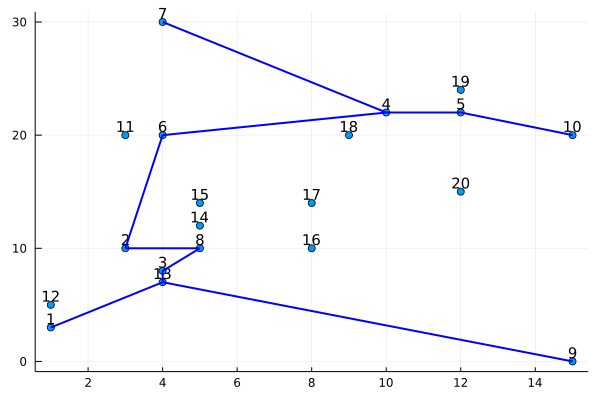


callbacks 52, cortes 2744
  2.939938 seconds (1.73 M allocations: 120.752 MiB, 24.99% compilation time)


In [12]:
# 3.2) Ejecute su función en tres instancias (i20.txt, i40.txt, i50.txt), 
# usando en todas ellas S=collect(1:10) y tomando el tiempo.

# i20.txt

@time resuelveSTSconCallbacks("i20.txt", collect(1:10))

callbacks 2, cortes 82
callbacks 3, cortes 100
callbacks 4, cortes 184
callbacks 5, cortes 264
callbacks 6, cortes 282
callbacks 7, cortes 362
callbacks 8, cortes 408
callbacks 9, cortes 450
callbacks 11, cortes 522
callbacks 12, cortes 596
callbacks 13, cortes 672
callbacks 14, cortes 742
callbacks 15, cortes 818
callbacks 16, cortes 892
callbacks 17, cortes 962
callbacks 18, cortes 1038
callbacks 19, cortes 1116
callbacks 20, cortes 1182
callbacks 21, cortes 1254
callbacks 22, cortes 1328
callbacks 23, cortes 1402
callbacks 24, cortes 1476
callbacks 25, cortes 1552
callbacks 26, cortes 1618
callbacks 27, cortes 1696
callbacks 28, cortes 1772
callbacks 29, cortes 1830
callbacks 30, cortes 1904
callbacks 31, cortes 1958
callbacks 32, cortes 2032
callbacks 33, cortes 2104
callbacks 34, cortes 2152
callbacks 35, cortes 2222
callbacks 36, cortes 2278
callbacks 37, cortes 2344
callbacks 38, cortes 2392
callbacks 39, cortes 2434
callbacks 40, cortes 2508
callbacks 41, cortes 2578
callbacks 

"Árbol óptimo encontrado, de largo 12"

"Número de pasos simplex:53029"

"Número de callbacks:180"

"Número de cortes agregados:9362"

"Vértices de Steiner usados: [34, 16]"

"Valor óptimo alcanzado: 214.40286412742626"

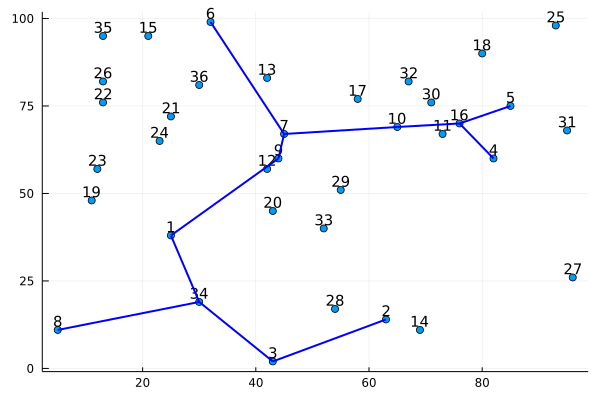


callbacks 176, cortes 9362
 13.004953 seconds (3.67 M allocations: 378.463 MiB, 1.62% gc time)


In [13]:
# i40.txt
@time resuelveSTSconCallbacks("i40.txt", collect(1:10))

callbacks 2, cortes 74
callbacks 3, cortes 120
callbacks 4, cortes 202
callbacks 5, cortes 268
callbacks 7, cortes 334
callbacks 8, cortes 414
callbacks 9, cortes 490
callbacks 10, cortes 572
callbacks 11, cortes 644
callbacks 12, cortes 718
callbacks 13, cortes 784
callbacks 14, cortes 854
callbacks 15, cortes 926
callbacks 16, cortes 998
callbacks 17, cortes 1064
callbacks 18, cortes 1136
callbacks 19, cortes 1218
callbacks 20, cortes 1298
callbacks 21, cortes 1368
callbacks 22, cortes 1426
callbacks 23, cortes 1504
callbacks 24, cortes 1582
callbacks 25, cortes 1646
callbacks 26, cortes 1724
callbacks 27, cortes 1796
callbacks 28, cortes 1874
callbacks 29, cortes 1946
callbacks 30, cortes 2016
callbacks 31, cortes 2090
callbacks 32, cortes 2146
callbacks 33, cortes 2212
callbacks 34, cortes 2282
callbacks 35, cortes 2366
callbacks 36, cortes 2444
callbacks 37, cortes 2510
callbacks 38, cortes 2576
callbacks 39, cortes 2648
callbacks 40, cortes 2714
callbacks 41, cortes 2788
callback

"Árbol óptimo encontrado, de largo 12"

"Número de pasos simplex:624261"

"Número de callbacks:145"

"Número de cortes agregados:8342"

"Vértices de Steiner usados: [27, 40]"

"Valor óptimo alcanzado: 174.93187511882442"

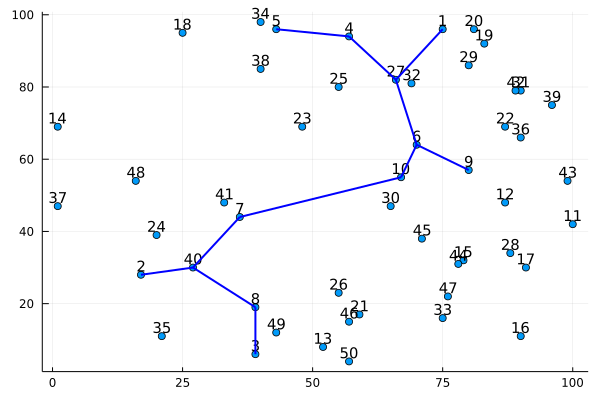


callbacks 145, cortes 8342
 55.532495 seconds (4.72 M allocations: 487.407 MiB, 0.37% gc time)


In [14]:
# i50.txt
@time resuelveSTSconCallbacks("i50.txt", collect(1:10))

# 🔴 F. Resolución de la relajación fraccional de STS

En instancias más grandes se hace complejo usar el esquema anterior pues estamos resolviendo demasiados PLE.
Una forma de mejorar esto es incluir restricciones de corte directamente  en su relajación fraccional.

El objetivo de esta sección es programar un método que resuelva la ** relajación fraccional** de STS 
(es decir, aquella en el cual eliminamos las condiciones de integralidad)

Para esto, seguiremos un esquema similar al de la sección D, crando una función ```resuelveSTSfraccional``` que haga lo siguiente.

1. Crear el modelo fraccional (por ejemplo, usando su función creamodeloSTS y luego quitando las restricciones de integralidad en las variables)
2. Repetir: 
    1. Encontrar solución $x$ para el modelo actual ($x$ puede ser fraccional)
    2. Determinar si $x$ satisface todas las restricciones de corte.  
         Si lo hace, terminar.  
         Si no lo hace, encontrar una o más restriccionds de corte insatisfecha y agregarla.  

Para implementar el paso 2, basta determinar si existen 2 terminales $s, t$, tal que el $s$-$t$ corte mínimo en el grafo completo bidirigido con capacidades $x$ tiene valor menor que 1. Si existe tal terminal, el corte asociado es exactamente lo buscado.

Lo ideal es usar un algoritmo combinatorial rápido para corte mínimo como Stoer-Watson o Queyranne; o uno aleatorizado como Karger.  En vez de eso, en este laboratorio calcularemos mincut mediante (una secuencia de) programas lineales puros. 

**Primero usaremos una función pre-hecha llamada cut(N,s,t,Z) que calcula el mincut de s a t usando un PL Puro que usa cortes, en el ejercicio 5 usted debe escribir una función nueva llamada flujo(N,s,t,Z) que calcula lo mismo, pero usando un PL Puro para flujos**




## F.1  Función pre-hecha para calcular cortes mínimos

La siguiente función pre-hecha calcula un $s$-$t$ corte mínimo de un grafo dirigido resolviendo el siguiente programa lineal puro.
\begin{align*}
min \sum_{i=1}^N\sum_{j=1}^N &q_{i,j}Z_{i,j}\\
p_s&\geq 1\\
p_t&=0\\
p_i-p_j+q(j,i)&\geq 0, \forall i,j\\
q&\ge 0
\end{align*}

Aquí las variables son los vectores q (largo) y p (potencial). Básicamente el PL busca asignar potenciales entre 0 y 1 a cada vértice y llama $q(i,j)$ a la diferencia de potencial entre $i$ y $j$. En un mundo ideal, una solución óptima asignaría potenciales 0 a aquellos puntos en el lado de $t$ y potencial 1 a aquellos puntos en el lado de $s$ del corte y luego $q_e=1$ solo para los arcos que cruzan el corte. Esta idea también funciona de manera fraccional y de hecho se puede probar que 
$$U=\{i \in [N], p_i\geq \alpha\}$$
es un $s$-$ t$ corte minimo para cualquier $\alpha$ estrictamente entre 0 y 1.


In [15]:
# calcula el mincut de s a t usando los valores de Z en un digrafo completo de N nodos.
function cut(N, s, t, Z)
    mincut = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV))) 
    set_optimizer_attributes(mincut, "OutputFlag" => 0, "TimeLimit" => 50)
    @variable(mincut, q[i=1:N, j=1:N]>=0)
    @variable(mincut, p[i=1:N])
    @objective(mincut, Min, sum(q[i,j]*Z[i,j] for i in 1:N, j in 1:N))
    @constraints(mincut, begin
            p[s]>=1
            p[t]==0
            Potencial[i=1:N,j=1:N], p[i]-p[j]+q[j,i]>=0
        end)
    optimize!(mincut)
    valor=objective_value(mincut)
    corte=findall(x->x>=1/2, value.(p))
    return valor, corte
end

cut (generic function with 1 method)

Puede probar la funcion anterior en el grafo con 6 vertices y pesos dados por el vector Z siguiente (para t=2, 3, 6 debería obtener cortes de valor 1, 2 y 3 respectivamente)

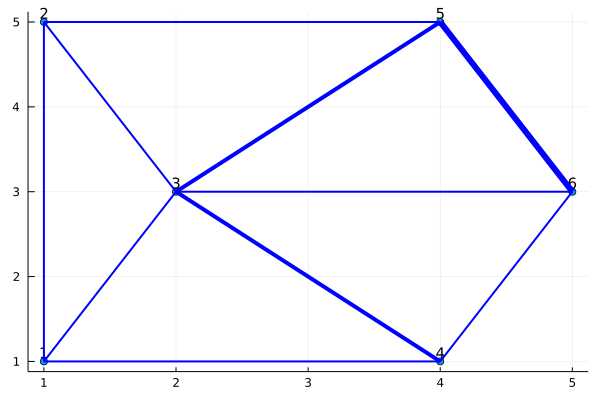

1-2 corte minimo: (1.0, [1, 3, 4, 5, 6])
2-3 corte minimo: (1.0, [2, 5, 6])
1-6 corte minimo: (3.0, [1])


In [16]:
xxpos=[1, 1, 2, 4, 4, 5]
yypos=[1, 5, 3, 1, 5, 3]
Z=zeros(6,6)
for (i,j,k) in [(1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 2), (3, 5, 2), (4, 6, 1), (5, 6, 3), (3,6,1), (2,5,1), (1,4,1)]
    Z[i,j]=k
end
dibujapesos(xxpos,yypos,Z)
println("1-2 corte minimo: ",cut(6,1,2,Z))
println("2-3 corte minimo: ",cut(6,2,3,Z))
println("1-6 corte minimo: ",cut(6,1,6,Z))


# 🔥 Ejercicio 4.  (15 puntos)

NOTA: Para este ejercicio, básese en la función ```resuelveDFZfraccional``` ubicada en el archivo `Lab2021-01-TSP.ipynb`


4.1) Complete la funcion ```resuelveSTSfraccional(nombrearchivo, S, bool)``` para resolver Steiner Tree fraccional. Esta función recibe tres parámetros.
     * nombrearchivo = nombre del archivo de la instancia
     * S = arreglo con los índices de los terminales.
     * bool = valor booleano que es ```true``` si se desea ejecutar usando la función de corte pre-escrita y ```false```si se desea usar la función de flujo que usted implementará en el ejercicio 5.

4.2) Ejecute la funcion ```resuelveSTSfraccional(nombrearchivo, S, bool)```  en tres instancias (i20.txt, i40.txt, i50.txt), usando en todas ellas S=collect(1:10) y bool=true, y tomando tiempo


In [17]:
# 4.1) Complete la funcion ```resuelveSTSfraccional``` para resolver Steiner Tree fraccional.

function resuelveSTSfraccional(nombrearchivo, S, bool)
    # si bool=true, se calcula usando corte
    # si bool=false, se calcula usando flujos
    
    # Crear modelo STS y remover integralidad
    N,posx,posy=leearchivo(nombrearchivo)
    E=[[i,j] for i in 1:N, j in 1:N if i<j]
    STS=creaModeloSTS(N,posx,posy,S)
    for var in STS[:x]
        unset_integer(var)
    end

    #iterar
    iter=0
    listo=false
    epsilon=0.0001 # tolerancia
    simplex=0
    cortesagregados=0
    while(!listo)
        listo=true   #si no encontramos cortes nuevo en la ejecución, terminamos al final del loop.
        iter+=1
        
        # optimizar, aumentar numero iteraciones simplex
        optimize!(STS)
        F=[[i,j] for i in 1:N, j in 1:N if i<j && value(STS[:x][i,j]) ≈ 1];
        
        # sumar a simplex el número de iteraciones usadas
        simplex= simplex + simplex_iterations(STS) 
        
        println("Iteración: ",iter, ", valor fraccional: ", objective_value(STS))

        # Crear capacidades Z bidirigidas a partir del PL resuelto           
        X=zeros(N,N)
        for i in 1:N, j in i+1:N
            X[i,j]=value(STS[:x][i,j])
            X[j,i]=X[i,j]
        end
        
        # Para cada par (s,t) de terminales, t>s
        # buscar si existe un s-t corte minimo de valor menor que 1-epsilon, 
        # Si existe, agregar restriccion asociada
      
        for s in S, t in S 
            if s<t
                #calcular s-t corte minimo
                if(bool)
                    valor, U = cut(N,s,t,X) 
                else
                    valor, U = flujo(N,s,t,X)
                end           
                if(valor < 1-epsilon)
                    #agregar restriccion
                    @constraint(STS, sum(STS[:x][e[1],e[2]] for e in E if (e[1] in U && !(e[2] in U)) || (e[2] in U && !(e[1] in U)))>=1)
                    cortesagregados+=1
                    listo=false # se encontro un corte, no se termina en esta iteracion
                end
            end
        end
    end
    
    # Solución encontrada, reportarla, reportar el numero de iteraciones simplex y dibujarla
                    
    valor=objective_value(STS)
    display(string("Árbol fraccional óptimo encontrado de largo ", valor))
    display(string("Número de pasos simplex:", Int(simplex_iterations(STS))))
    display(string("Número de cortes agregados:", cortesagregados))
    pesos=zeros(N,N)
    for i in 1:N, j in i+1:N
        pesos[i,j]=value(STS[:x][i,j])
    end
    dibujapesos(posx,posy,pesos)
    return nothing
end

resuelveSTSfraccional (generic function with 1 method)

Iteración: 1, valor fraccional: 31.81210689119769
Iteración: 2, valor fraccional: 33.04924708207538
Iteración: 3, valor fraccional: 36.20923571671853
Iteración: 4, valor fraccional: 37.150787969985544
Iteración: 5, valor fraccional: 38.069818893267524
Iteración: 6, valor fraccional: 38.640779078446364
Iteración: 7, valor fraccional: 39.24144571271991
Iteración: 8, valor fraccional: 39.48846735969268
Iteración: 9, valor fraccional: 39.949947766269965


"Árbol fraccional óptimo encontrado de largo 40.02013391610316"

"Número de pasos simplex:2"

"Número de cortes agregados:322"

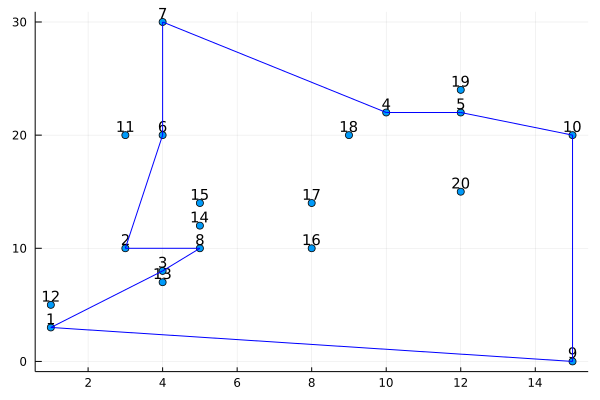

Iteración: 10, valor fraccional: 40.02013391610316
  6.660433 seconds (27.44 M allocations: 3.092 GiB, 13.39% gc time, 2.83% compilation time)


In [18]:
# 4.2) Ejecute su funcion en tres instancias (i20.txt, i40.txt, i50.txt), usando en todas ellas S=collect(1:10) y tomando el tiempo.

# i20.txt

@time resuelveSTSfraccional("i20.txt", collect(1:10), true)

Iteración: 1, valor fraccional: 99.24344032680287
Iteración: 2, valor fraccional: 115.15062790089183
Iteración: 3, valor fraccional: 123.0885548401284
Iteración: 4, valor fraccional: 127.89585337425449
Iteración: 5, valor fraccional: 134.16722804156555
Iteración: 6, valor fraccional: 139.24373640188102
Iteración: 7, valor fraccional: 142.124309927251
Iteración: 8, valor fraccional: 142.65001761459519
Iteración: 9, valor fraccional: 143.2932544273416
Iteración: 10, valor fraccional: 143.81690331023697
Iteración: 11, valor fraccional: 145.70274519795674
Iteración: 12, valor fraccional: 146.82408635024322
Iteración: 13, valor fraccional: 147.06165889797057
Iteración: 14, valor fraccional: 147.32948718572817
Iteración: 15, valor fraccional: 148.1704653326664
Iteración: 16, valor fraccional: 148.38784463121064


"Árbol fraccional óptimo encontrado de largo 148.6003905712567"

"Número de pasos simplex:12"

"Número de cortes agregados:673"

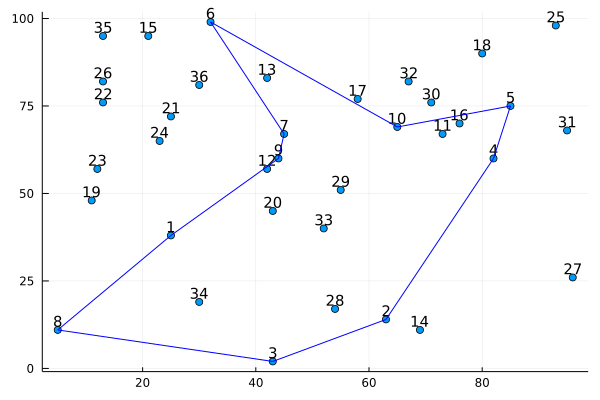

Iteración: 17, valor fraccional: 148.6003905712567
 34.325835 seconds (142.33 M allocations: 16.565 GiB, 14.01% gc time)


In [19]:
# i40.txt
@time resuelveSTSfraccional("i40.txt", collect(1:10), true)

Iteración: 1, valor fraccional: 65.7633421680189
Iteración: 2, valor fraccional: 81.14525326506956
Iteración: 3, valor fraccional: 90.75691408459797
Iteración: 4, valor fraccional: 98.30429946365565
Iteración: 5, valor fraccional: 101.3839418016772
Iteración: 6, valor fraccional: 105.82234947844273
Iteración: 7, valor fraccional: 108.1031502789623
Iteración: 8, valor fraccional: 109.54753774556295
Iteración: 9, valor fraccional: 110.93427920847219
Iteración: 10, valor fraccional: 111.49419792085462
Iteración: 11, valor fraccional: 111.84601822267236
Iteración: 12, valor fraccional: 113.84908689159649
Iteración: 13, valor fraccional: 114.52953019766522
Iteración: 14, valor fraccional: 114.75245118689023
Iteración: 15, valor fraccional: 115.15590853427344
Iteración: 16, valor fraccional: 117.24246972433954
Iteración: 17, valor fraccional: 117.39407202159109
Iteración: 18, valor fraccional: 117.73702235494862
Iteración: 19, valor fraccional: 118.0731100988514
Iteración: 20, valor fraccion

"Árbol fraccional óptimo encontrado de largo 128.51445799870515"

"Número de pasos simplex:13"

"Número de cortes agregados:1879"

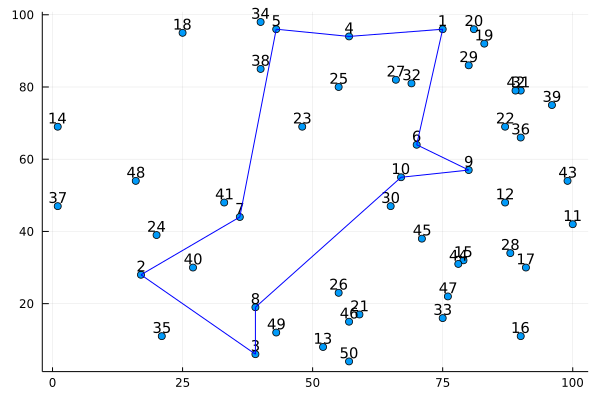

Iteración: 49, valor fraccional: 128.51445799870515
187.394939 seconds (783.46 M allocations: 90.751 GiB, 14.07% gc time)


In [20]:
# i50.txt
@time resuelveSTSfraccional("i50.txt", collect(1:10), true)

# 🔥 Ejercicio 5.  (15 puntos)

También es posible calcular el corte mínimo de un nodo s a un nodo t en un digrafo completo con capacidades Z calculando primero un s-t flujo máximo, luego calculando la red residual resultante y finalmente calculando los nodos alcanzables desde s en la red residual

Recordatorio:

El siguiente programa lineal puro calcula un s-t flujo máximo en una red completa con vértices $V=1:N$ y capacidades $Z$.

\begin{align*}
\max f(\delta^+(s))-f(\delta^-(s))\\
f(\delta^+(v))-f(\delta^-(v))&=0, &\forall v\in V\setminus\{s,t\}\\
f_{i,j}&\leq Z_{i,j}, &\forall (i,j).\\
f&\ge 0
\end{align*}

Si $f$ es un $s$-$t$ flujo máximo, definimos (el soporte) de red residual como los arcos
$H=\{(i,j)\colon f_{i,j}<Z_{i,j}\}\cup \{(i,j)\colon f_{j,i}>0\}$

Por problemas numéricos, es mejor definirlo como
$H=\{(i,j)\colon f_{i,j}<Z_{i,j}-epsilon\}\cup \{(i,j)\colon f_{j,i}>epsilon\}$, para un epsilon pequeño, digamos 0.0001.

Del curso de algoritmos combinatoriales, usted sabe que el conjunto de todos los nodos alcanzables desde $1$ en el digrafo $(V,H)$ es un $1-t$ corte mínimo.

5.1) Cree una función ```flujo(N, s, t, Z)```que haga lo siguiente
    * Calcule un $s$-$t$ flujo máximo resolviendo el PL asociado
    * Calcule el soporte de la red residual $H$ asociada al óptimo
    * Devuelva valor, corte.  Donde valor es el valor del flujo máximo (= corte mínimo) y corte es el conjunto de nodos alcanzables desde $s$ en el digrafo $(V,H)$. 
    
    Nota: Pruebe la función en el mismo grafo de 6 vértices que aparece después de la descripción de la función cut(N,s,t,Z) de este archivo para verificar que obtiene los mismos valores que dicha función
    
5.2) Ejecute la funcion ```resuelveSTSfraccional(nombrearchivo, S, bool)```  en tres instancias (i20.txt, i40.txt, i50.txt), usando en todas ellas S=collect(1:10) y bool=false, y tomando tiempo


In [21]:
# 5.1) Cree la  función ```flujo(N, s, t, Z)```

function flujo(N, s, t, Z)
    #  Crar modelo para flujo maximo
    maxflow = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV))) 
    set_optimizer_attributes(maxflow, "OutputFlag" => 0, "TimeLimit" => 50)
    @variable(maxflow, f[i=1:N, j=1:N]>=0)
    @objective(maxflow, Max, sum(f[s,w]-f[w,s] for w in 1:N if w!=s))
    @constraints(maxflow, begin
            [i=1:N, j=1:N], f[i,j] <= Z[i,j]
            [v in setdiff(1:N,[s,t])], sum(f[v,w]-f[w,v] for w in 1:N if w!=v)==0
        end)
       
    # Resolver el PL y calcular el soporte de la red residual
    optimize!(maxflow)
    valor=objective_value(maxflow)
    epsilon=0.0001
    
    H=[[i,j] for i in 1:N, j in 1:N if (value(f[i,j])<Z[i,j]-epsilon) || (value(f[j,i])>epsilon)]
    
    # Encuentre el conjunto de nodos alcanzables desde 1 en (V,H)
    corte = encuentracomponentedirigida(N,s,H)
    return valor, corte
end

flujo (generic function with 1 method)

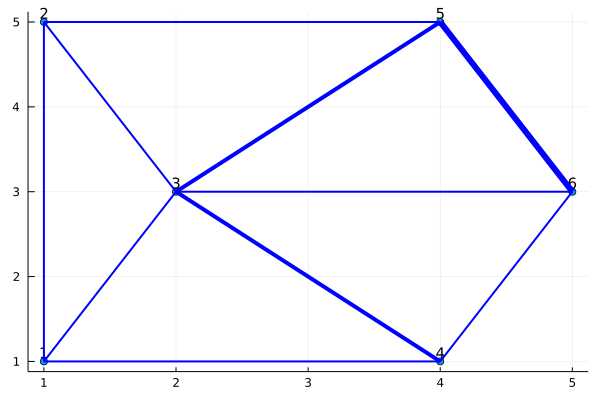

1-2 corte minimo: (1.0, [1, 4, 6, 3, 5])
2-3 corte minimo: (1.0, [2, 5, 6])
1-6 corte minimo: (3.0, [1])


In [22]:
# Puede probar su funcion acá
xxpos=[1, 1, 2, 4, 4, 5]
yypos=[1, 5, 3, 1, 5, 3]
Z=zeros(6,6)
for (i,j,k) in [(1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 2), (3, 5, 2), (4, 6, 1), (5, 6, 3), (3,6,1), (2,5,1), (1,4,1)]
    Z[i,j]=k
end
dibujapesos(xxpos,yypos,Z)
println("1-2 corte minimo: ",flujo(6,1,2,Z))
println("2-3 corte minimo: ",flujo(6,2,3,Z))
println("1-6 corte minimo: ",flujo(6,1,6,Z))


Iteración: 1, valor fraccional: 31.81210689119769
Iteración: 2, valor fraccional: 33.04924708207538
Iteración: 3, valor fraccional: 36.20923571671853
Iteración: 4, valor fraccional: 37.150787969985544
Iteración: 5, valor fraccional: 38.069818893267524
Iteración: 6, valor fraccional: 38.640779078446364
Iteración: 7, valor fraccional: 39.24144571271991
Iteración: 8, valor fraccional: 39.48846735969268
Iteración: 9, valor fraccional: 39.949947766269965


"Árbol fraccional óptimo encontrado de largo 40.02013391610316"

"Número de pasos simplex:2"

"Número de cortes agregados:322"

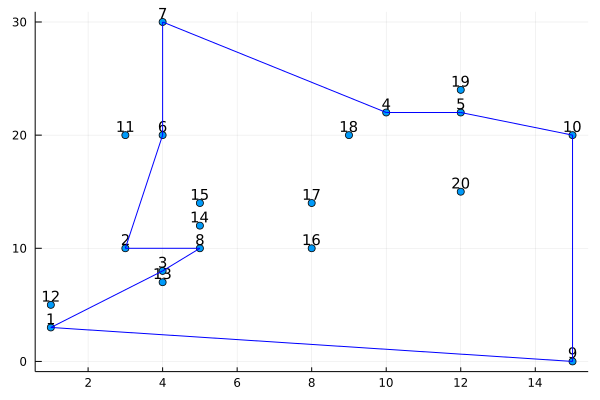

Iteración: 10, valor fraccional: 40.02013391610316
  6.857932 seconds (29.08 M allocations: 2.997 GiB, 12.48% gc time, 0.18% compilation time)


In [23]:
# 5.2) Ejecute la funcion ```resuelveSTSfraccional(nombrearchivo, S, bool)```  en tres instancias (i20.txt, i40.txt, i50.txt), usando en todas ellas S=collect(1:10) y bool=false, y tomando tiempo

# i20.txt

@time resuelveSTSfraccional("i20.txt", collect(1:10), false)

Iteración: 1, valor fraccional: 99.24344032680287
Iteración: 2, valor fraccional: 115.15062790089183
Iteración: 3, valor fraccional: 123.0885548401284
Iteración: 4, valor fraccional: 127.89585337425449
Iteración: 5, valor fraccional: 134.16722804156555
Iteración: 6, valor fraccional: 139.03744568160334
Iteración: 7, valor fraccional: 141.4022197372034
Iteración: 8, valor fraccional: 142.65001761459519
Iteración: 9, valor fraccional: 143.64371727382786
Iteración: 10, valor fraccional: 144.33004655891327
Iteración: 11, valor fraccional: 144.88838505810887
Iteración: 12, valor fraccional: 145.80621783654067
Iteración: 13, valor fraccional: 146.17948998323058
Iteración: 14, valor fraccional: 147.00876151220268
Iteración: 15, valor fraccional: 147.54200176549787
Iteración: 16, valor fraccional: 147.86337891829714
Iteración: 17, valor fraccional: 148.34736302121883


"Árbol fraccional óptimo encontrado de largo 148.60039057125667"

"Número de pasos simplex:4"

"Número de cortes agregados:750"

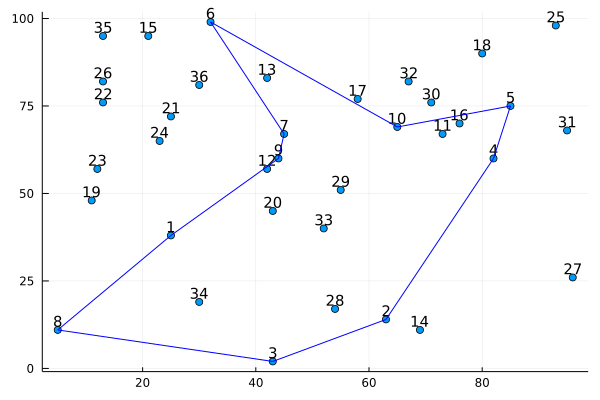

Iteración: 18, valor fraccional: 148.60039057125667
 37.048104 seconds (161.82 M allocations: 16.968 GiB, 12.85% gc time)


In [24]:
# i40.txt
@time resuelveSTSfraccional("i40.txt", collect(1:10), false)

Iteración: 1, valor fraccional: 65.7633421680189
Iteración: 2, valor fraccional: 81.14525326506956
Iteración: 3, valor fraccional: 90.75691408459797
Iteración: 4, valor fraccional: 97.30336380989047
Iteración: 5, valor fraccional: 100.98769218743242
Iteración: 6, valor fraccional: 105.82234947844273
Iteración: 7, valor fraccional: 108.1031502789623
Iteración: 8, valor fraccional: 108.82833101921334
Iteración: 9, valor fraccional: 111.32801368074082
Iteración: 10, valor fraccional: 111.79348910305555
Iteración: 11, valor fraccional: 111.87788485833032
Iteración: 12, valor fraccional: 114.29381445353762
Iteración: 13, valor fraccional: 114.58611722036625
Iteración: 14, valor fraccional: 115.10352914106679
Iteración: 15, valor fraccional: 115.46195779671376
Iteración: 16, valor fraccional: 117.39407202159109
Iteración: 17, valor fraccional: 117.46413920687253
Iteración: 18, valor fraccional: 117.8653102201289
Iteración: 19, valor fraccional: 118.11178674988096
Iteración: 20, valor fraccio

"Árbol fraccional óptimo encontrado de largo 128.51445799870606"

"Número de pasos simplex:12"

"Número de cortes agregados:2182"

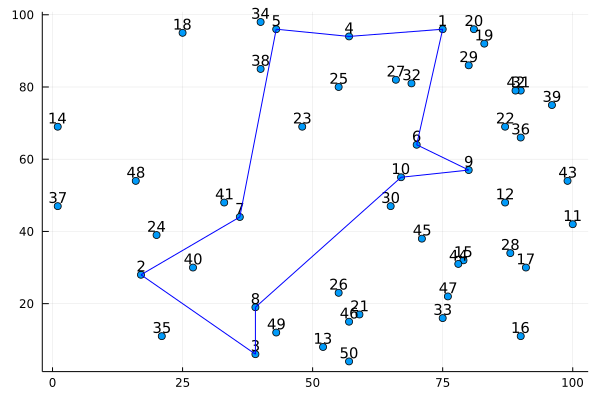

Iteración: 52, valor fraccional: 128.51445799870606
204.066011 seconds (889.81 M allocations: 92.584 GiB, 13.03% gc time)


In [25]:
# i50.txt
@time resuelveSTSfraccional("i50.txt", collect(1:10), false)